In [249]:
import numpy as np
import matplotlib.pyplot as plt

In [250]:
class RandomAction:
    def __init__(self, n_states=19, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self, action):
        if action == 0:
            action = -1
        self.state += action
        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [251]:
class n_TD_off_policy:
    def __init__(self, n, alpha):
        self.n = n
        self.alpha = alpha
        self.V = np.zeros(19)
        self.gamma = 0.9
        self.epsilon = 0.1

    def get_policy(self, state, epsilon=0.):
        if state == 0:
            V_table = [-1, self.V[state+1]]
        elif state == len(self.V) - 1:
            V_table = [self.V[state-1], 1]
        else:
            V_table = [self.V[state-1], self.V[state+1]]
        
        if V_table[0] == V_table[1]:
            return [0.5, 0.5]
        elif V_table[0] > V_table[1]:
            return [1, 0]
        else:
            return [0, 1]
    
    def get_rho(self, state, action):
        # return self.get_policy(state)[action] / self.get_policy(state, epsilon=0.1)[action]
        return self.get_policy(state)[action] / 0.5
    
    def do(self):
        env = RandomAction()
        episodes = 1000

        for episode in range(episodes):
            states = []
            actions = []
            rewards = []

            state = env.reset()
            states.append(state)

            t = 0
            T = 100000
            while True:
                if t < T:
                    action = np.random.choice([0, 1], p=[0.5, 0.5])
                    actions.append(action)

                    state, reward, done = env.step(action)
                    states.append(state)
                    rewards.append(reward)

                    if done:
                        T = t + 1

                tau = t - self.n + 1
                if tau >= 0:
                    rho = np.prod([self.get_rho(states[i], actions[i]) for i in range(tau, min(tau+self.n, T))])
                    G = sum([self.gamma ** (i-tau) * rewards[i] for i in range(tau, min(tau+self.n, T))])
                    if tau + self.n < T:
                        G += self.gamma ** self.n * self.V[states[tau+self.n]]
                    self.V[states[tau]] += self.alpha * rho * (G - self.V[states[tau]])
                    # print(state, t, states[tau], T, self.V)
                if tau == T - 1:
                    break
                t += 1
                # sleep(0.01)

In [252]:
class n_TD_off_policy_control:
    def __init__(self, n, alpha):
        self.n = n
        self.alpha = alpha
        self.V = np.zeros(19)
        self.gamma = 0.9
        self.epsilon = 0.1

    def get_policy(self, state):
        if state == 0:
            V_table = [-1, self.V[state+1]]
        elif state == len(self.V) - 1:
            V_table = [self.V[state-1], 1]
        else:
            V_table = [self.V[state-1], self.V[state+1]]
        
        if V_table[0] == V_table[1]:
            return [0.5, 0.5]
        elif V_table[0] > V_table[1]:
            return [1, 0]
        else:
            return [0, 1]
    
    def get_rho(self, state, action):
        # return self.get_policy(state)[action] / self.get_policy(state, epsilon=0.1)[action]
        return self.get_policy(state)[action] / 0.5
    
    def do(self):
        env = RandomAction()
        episodes = 1000

        for episode in range(episodes):
            states = []
            actions = []
            rewards = []

            state = env.reset()
            states.append(state)

            t = 0
            T = 100000
            while True:
                if t < T:
                    action = np.random.choice([0, 1], p=[0.5, 0.5])
                    actions.append(action)

                    state, reward, done = env.step(action)
                    states.append(state)
                    rewards.append(reward)

                    if done:
                        T = t + 1

                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    prod_rho = 1
                    for i in range(tau, min(tau+self.n, T)):
                        rho = self.get_rho(states[i], actions[i])
                        G += (rho * rewards[i] + (1 - rho) * self.V[states[i]]) * self.gamma ** (i-tau) * prod_rho
                        prod_rho *= rho

                    if tau + self.n < T:
                        G += prod_rho * self.gamma ** self.n * self.V[states[tau+self.n]]

                    self.V[states[tau]] += self.alpha * (G - self.V[states[tau]])

                if tau == T - 1:
                    break
                t += 1

In [253]:
import time

t1 = time.time()

td1 = n_TD_off_policy(4, 0.01)
td1.do()

print(time.time() - t1)

t2 = time.time()

td2 = n_TD_off_policy_control(4, 0.01)
td2.do()

print(time.time() - t2)

0.9336330890655518
0.7446420192718506


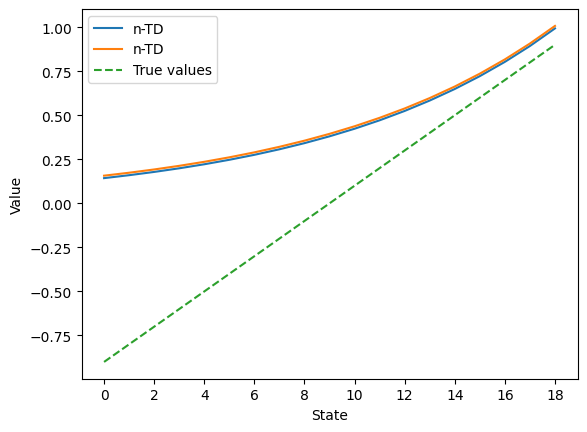

In [254]:
plt.plot(td1.V-0.007, label='n-TD')
plt.plot(td2.V+0.007, label='n-TD')
plt.plot(np.arange(1, 20)/20*2-1, '--', label='True values')
plt.xlabel('State')
plt.xticks(range(0, 19, 2))
plt.ylabel('Value')
plt.legend()
plt.show()